In [1]:
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from aeon.datasets import load_airline

plt.rcParams.update(
    {
        "figure.figsize": (21,14), 
        "font.size": 24, 
        "lines.linewidth": 3,
        "legend.loc": "upper right", 
        "axes.labelpad": 16
    }
)

# Introduction

### Distributional Forecast example

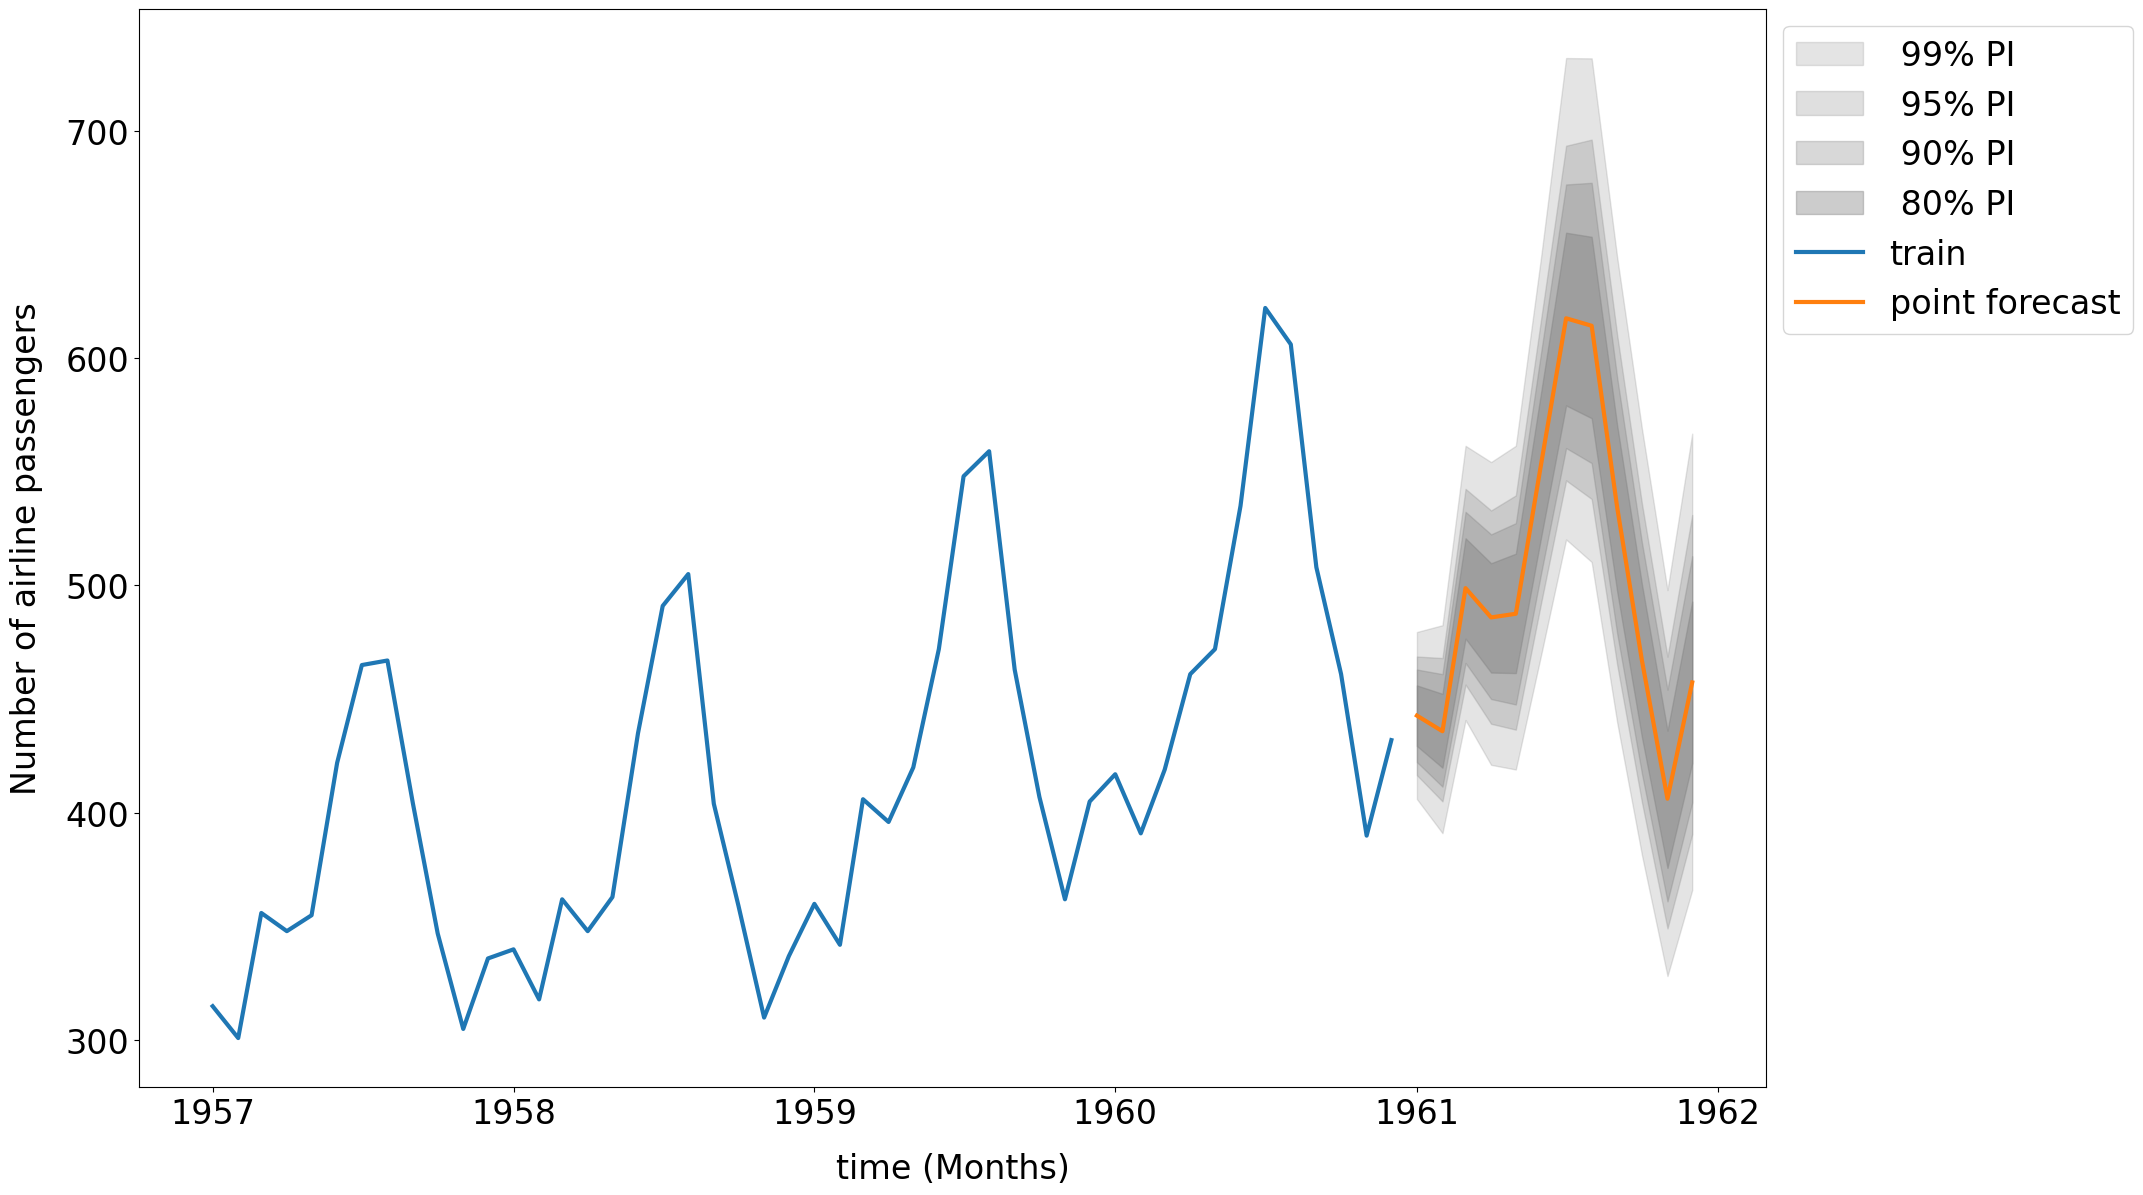

In [2]:
def plot_prediction_intervals_from_simulations(
    y_train,
    simulations,
    intervals,
    y_test = None,
    point_pred = None,
    min_opacity=0.7,
    max_opacity=0.2,
    plot_mean=False,
    plot_median=False
):
    """Plots prediction intervals from statsmodels simulated forecasts"""
    # map the intervals to the corresponding enclosing quantiles
    d = {i: (1-i, i) for i in intervals}
    opacity_coef = lambda x: (
        2 * x * (max_opacity - min_opacity) - max_opacity + 2 * min_opacity
    )
    
    plt.figure()
    for key, val in d.items():
        upper = simulations.quantile(val[0], axis=1)
        lower = simulations.quantile(val[1], axis=1)
        plt.fill_between(
            lower.index,
            lower,
            upper,
            color="grey",
            alpha=opacity_coef(key),
            label=f"{100*key: 0.0f}% PI",
        )
    
    plt.plot(y_train, label="train")
    if y_test is not None:
        plt.plot(y_test,label="test")
    if plot_median:
        plt.plot(simulations.median(axis=1), label="prediction median")
    if plot_mean:
        plt.plot(simulations.mean(axis=1), label="prediction mean")
    if point_pred is not None:
        plt.plot(point_pred, label="point forecast")
    
    plt.xlabel(f"time (Months)")
    plt.ylabel(y_train.name)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# example data 
y = load_airline(return_array=False)
y.index = y.index.to_timestamp()    
    
model = ETSModel(
    endog=y, 
    seasonal_periods=12, 
    error="mul", 
    seasonal="mul", 
    trend="add",
)
results = model.fit(disp=0)
sims = results.simulate(
    nsimulations=12, 
    repetitions=10000, 
    anchor="end", 
    random_state=42
)
point_pred = results.forecast(12)
plot_prediction_intervals_from_simulations(
    y.iloc[-48:], sims, [0.99, 0.95, 0.9, 0.8], point_pred=point_pred
)
plt.savefig("images/cell04_ets_prediction_intervals.png", bbox_inches="tight", dpi=150)
plt.show()

## Point forecasts

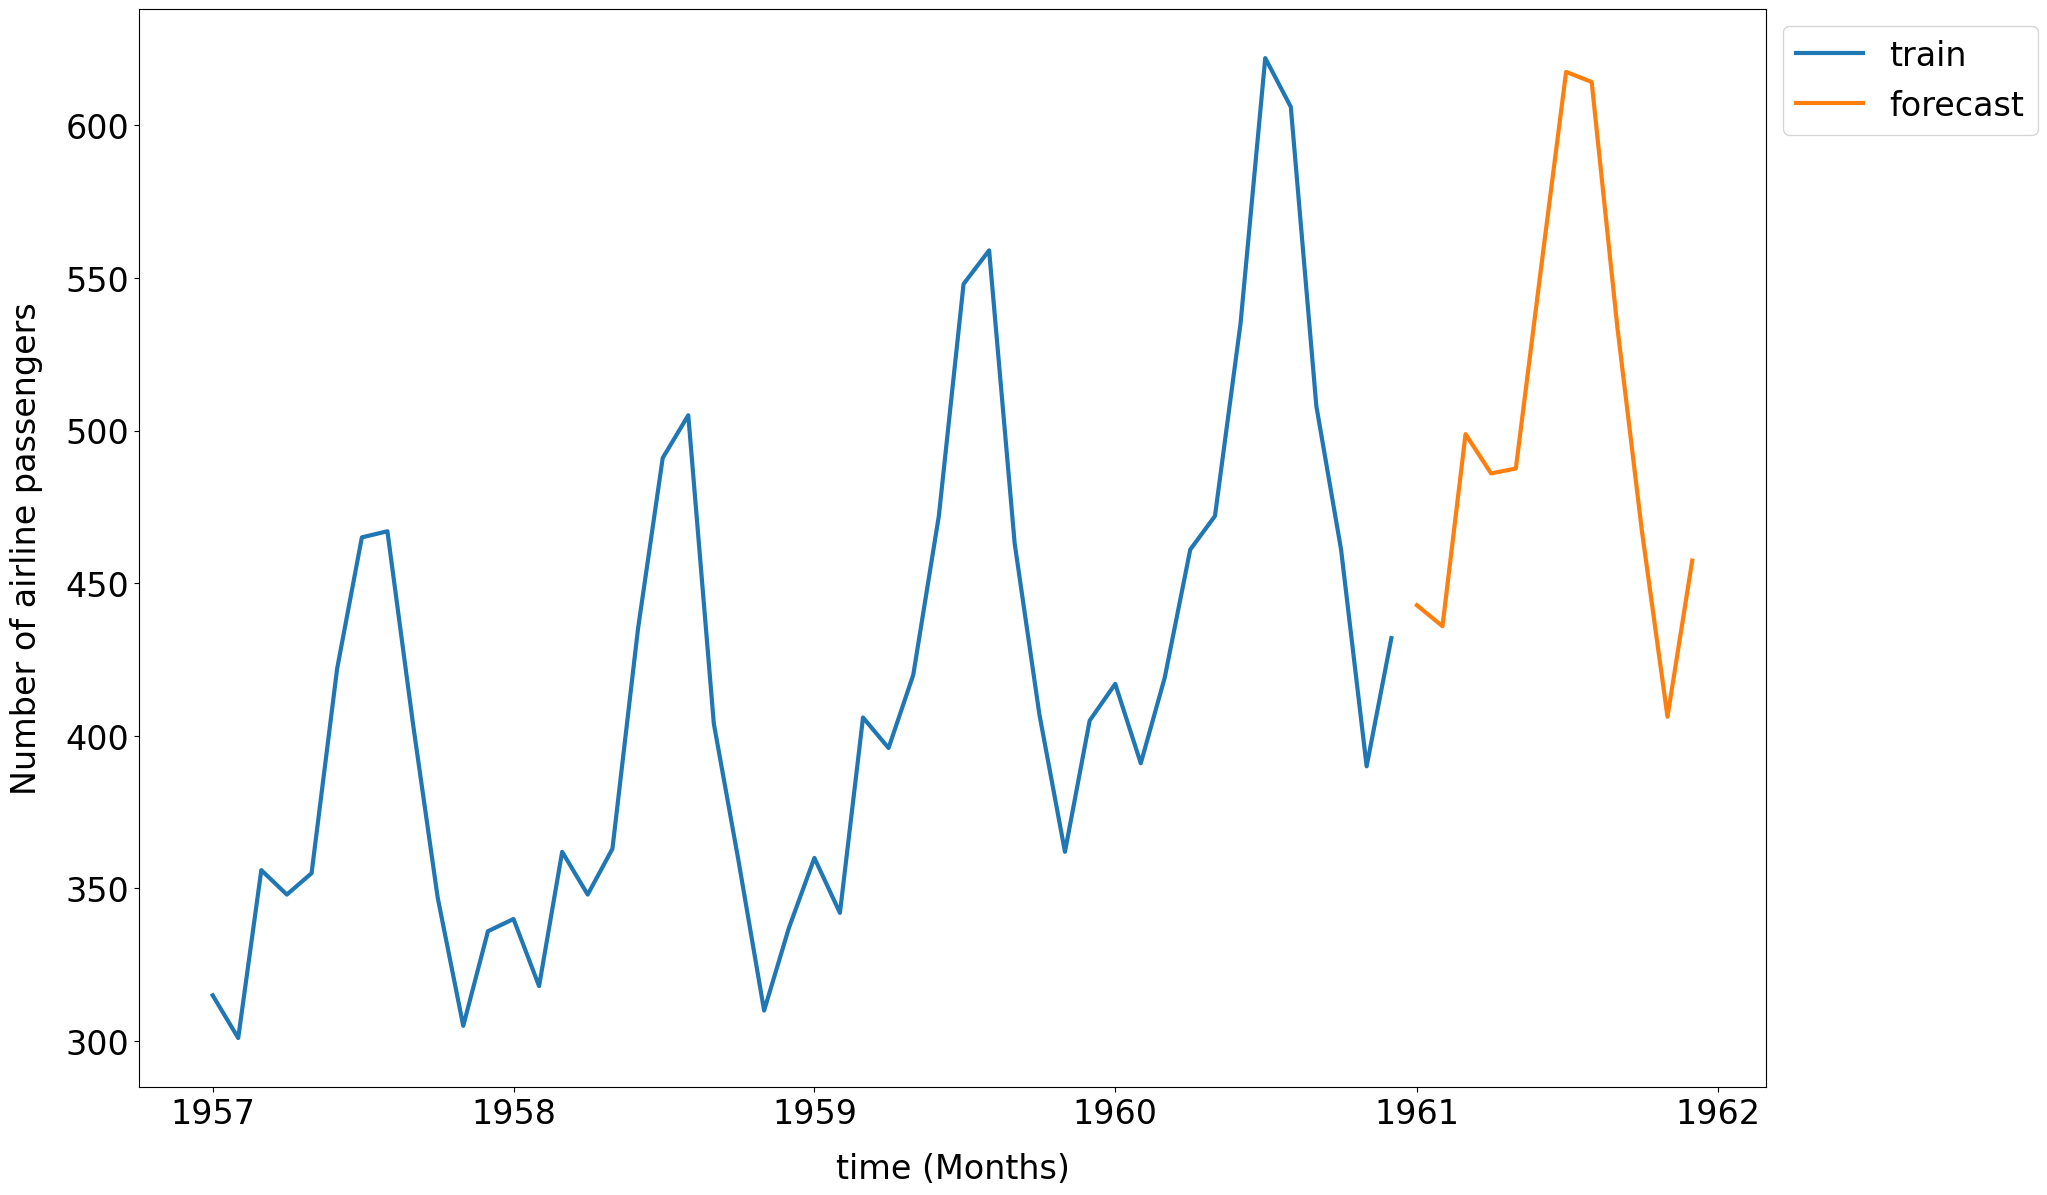

In [3]:
model = ETSModel(
    endog=y, 
    seasonal_periods=12, 
    error="mul", 
    seasonal="mul", 
    trend="add",
)
results = model.fit(disp=0)
point_fcast = results.forecast(12)
plt.plot(y.iloc[-48:], label="train")
plt.plot(point_fcast, label="forecast")
plt.xlabel(f"time (Months)")
plt.ylabel(y.name)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("images/cell06_ets_point_forecast.png", bbox_inches="tight", dpi=150)
plt.show()

### CV example

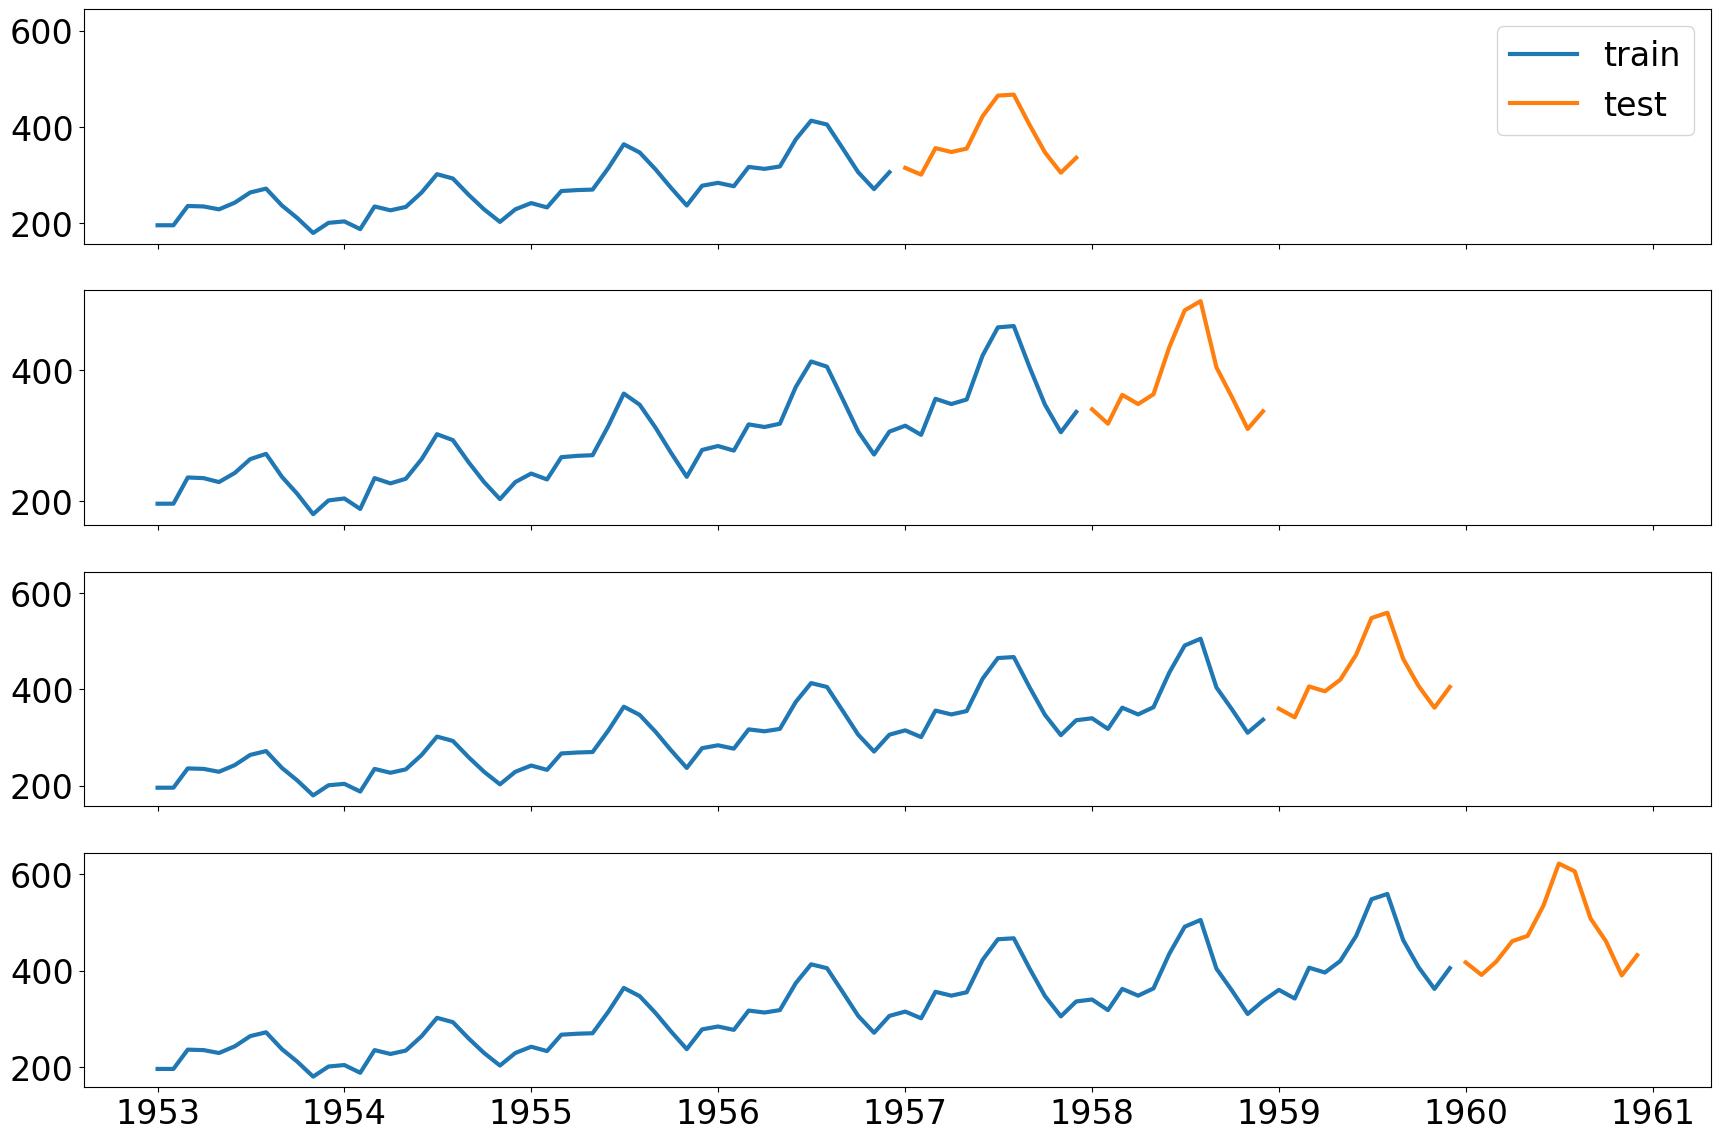

In [4]:
y = load_airline(return_array=False)
y.index = y.index.to_timestamp()
bottom_lim = -96

ax1 = plt.subplot(411)
# plot_series(y.iloc[:-48], y.iloc[-48:-36])
plt.plot(y.iloc[bottom_lim:-48], label="train")
plt.plot(y.iloc[-48:-36], label="test")
plt.tick_params('x', labelbottom=False)

# share x only
ax2 = plt.subplot(412, sharex=ax1)
# make these tick labels invisible
plt.plot(y.iloc[bottom_lim:-36], label="train")
plt.plot(y.iloc[-36:-24], label="test")
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = plt.subplot(413, sharex=ax1, sharey=ax1)
plt.plot(y.iloc[bottom_lim:-24], label="train")
plt.plot(y.iloc[-24:-12], label="test")
plt.tick_params('x', labelbottom=False)

ax4 = plt.subplot(414, sharex=ax1, sharey=ax1)
plt.plot(y.iloc[bottom_lim:-12], label="train")
plt.plot(y.iloc[-12:], label="test")

ax1.legend()
plt.savefig("images/cell08_cv_folds.png", bbox_inches="tight", dpi=150)
plt.show()

# Point Forecasting metrics

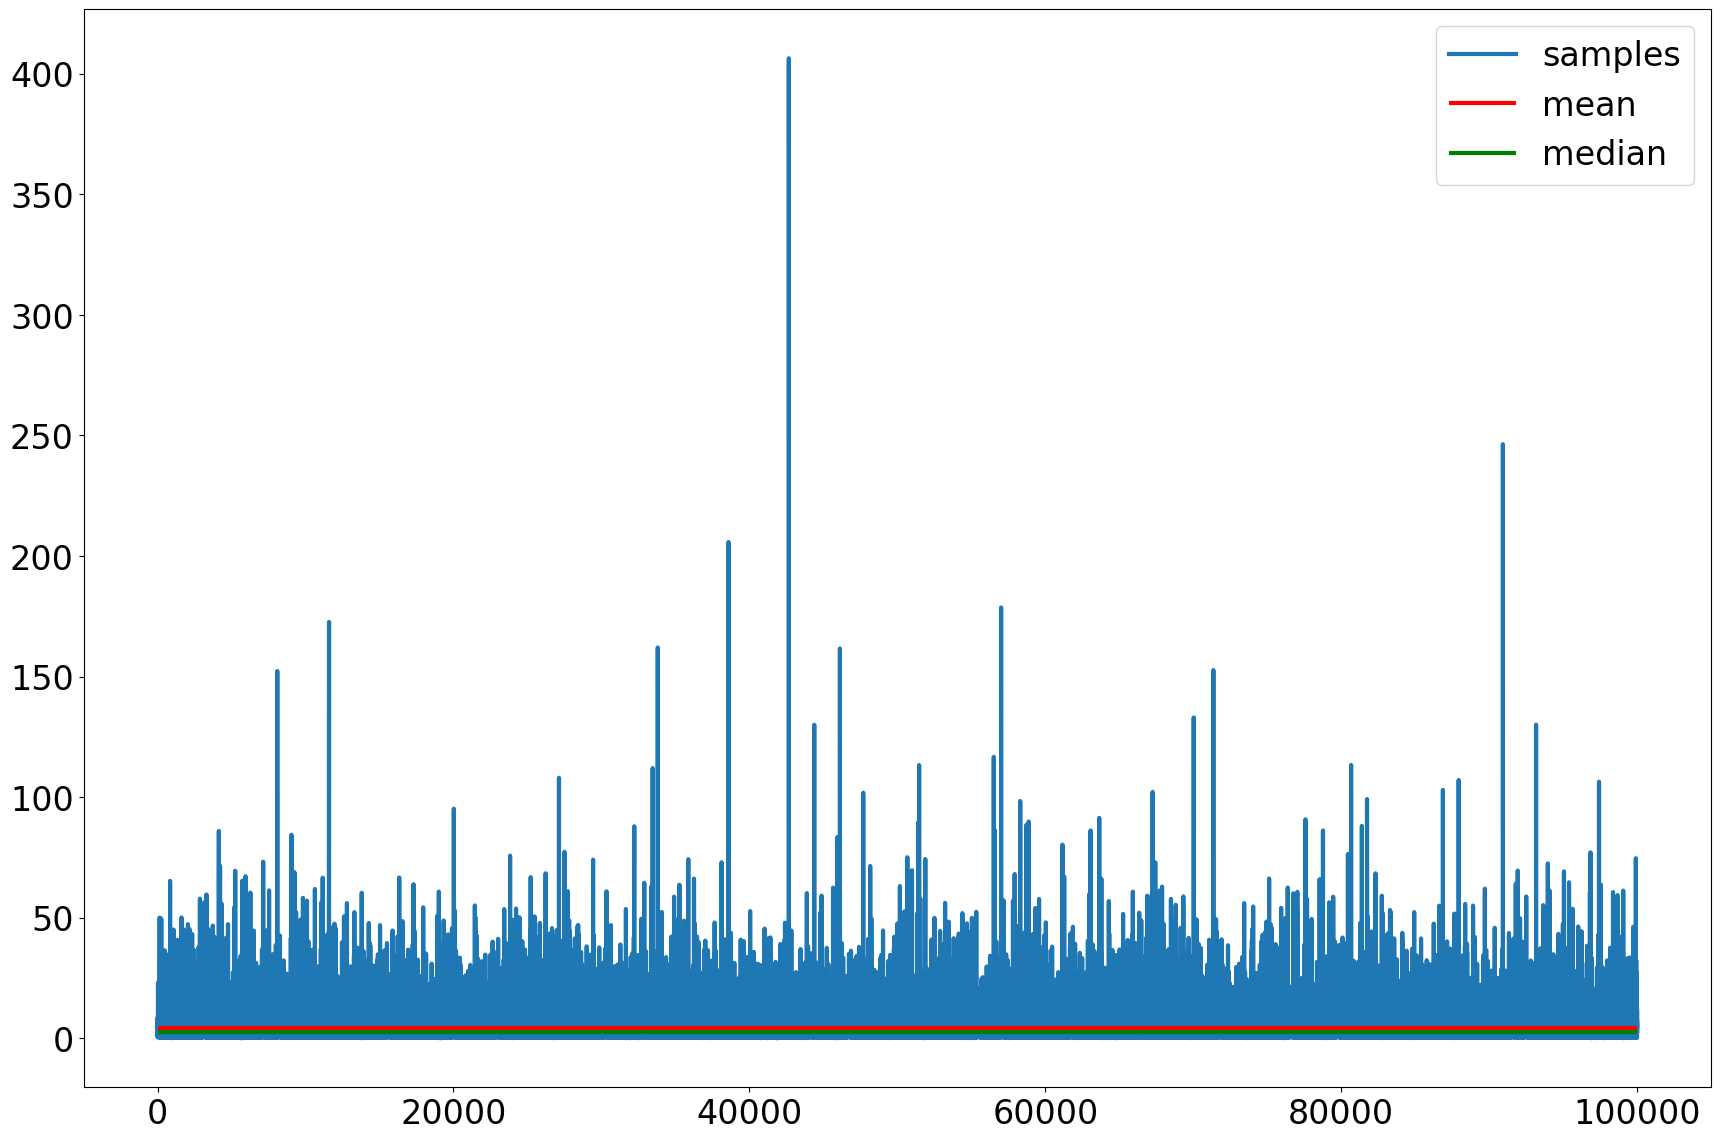

In [5]:
rng = np.random.default_rng(seed=42)

# lognormal stats functions:
lognormal_mean = lambda m, s: np.exp(m+((s**2)/2))
lognormal_median = lambda m: np.exp(m)

m = 1
s = 1
num_samples = 100000
synthetic_ts = rng.lognormal(m, s, num_samples).reshape(-1, 1)

plt.plot(synthetic_ts, label="samples")
plt.hlines(lognormal_mean(m, s), 0, num_samples, color="r", label="mean")
plt.hlines(lognormal_median(m), 0, num_samples, color="g", label="median")
plt.legend()
plt.savefig("images/cell10_lognormal_synthetic_ts.png", bbox_inches="tight", dpi=150)
plt.show()

In [6]:
# Error metrics
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=1)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2, axis=1))

def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)/y_true, axis=1)

def minmax_scale(y):
    return (y - np.min(y)) / (np.max(y)-np.min(y))

In [7]:
max_x = 10
min_x = 0
prediction_grid = np.arange(min_x, max_x, step=0.001).reshape(-1, 1)
rmse_prediction_grid = minmax_scale(rmse(synthetic_ts.T, prediction_grid))
mae_prediction_grid = minmax_scale(mae(synthetic_ts.T, prediction_grid))
mape_prediction_grid = minmax_scale(mape(synthetic_ts.T, prediction_grid))

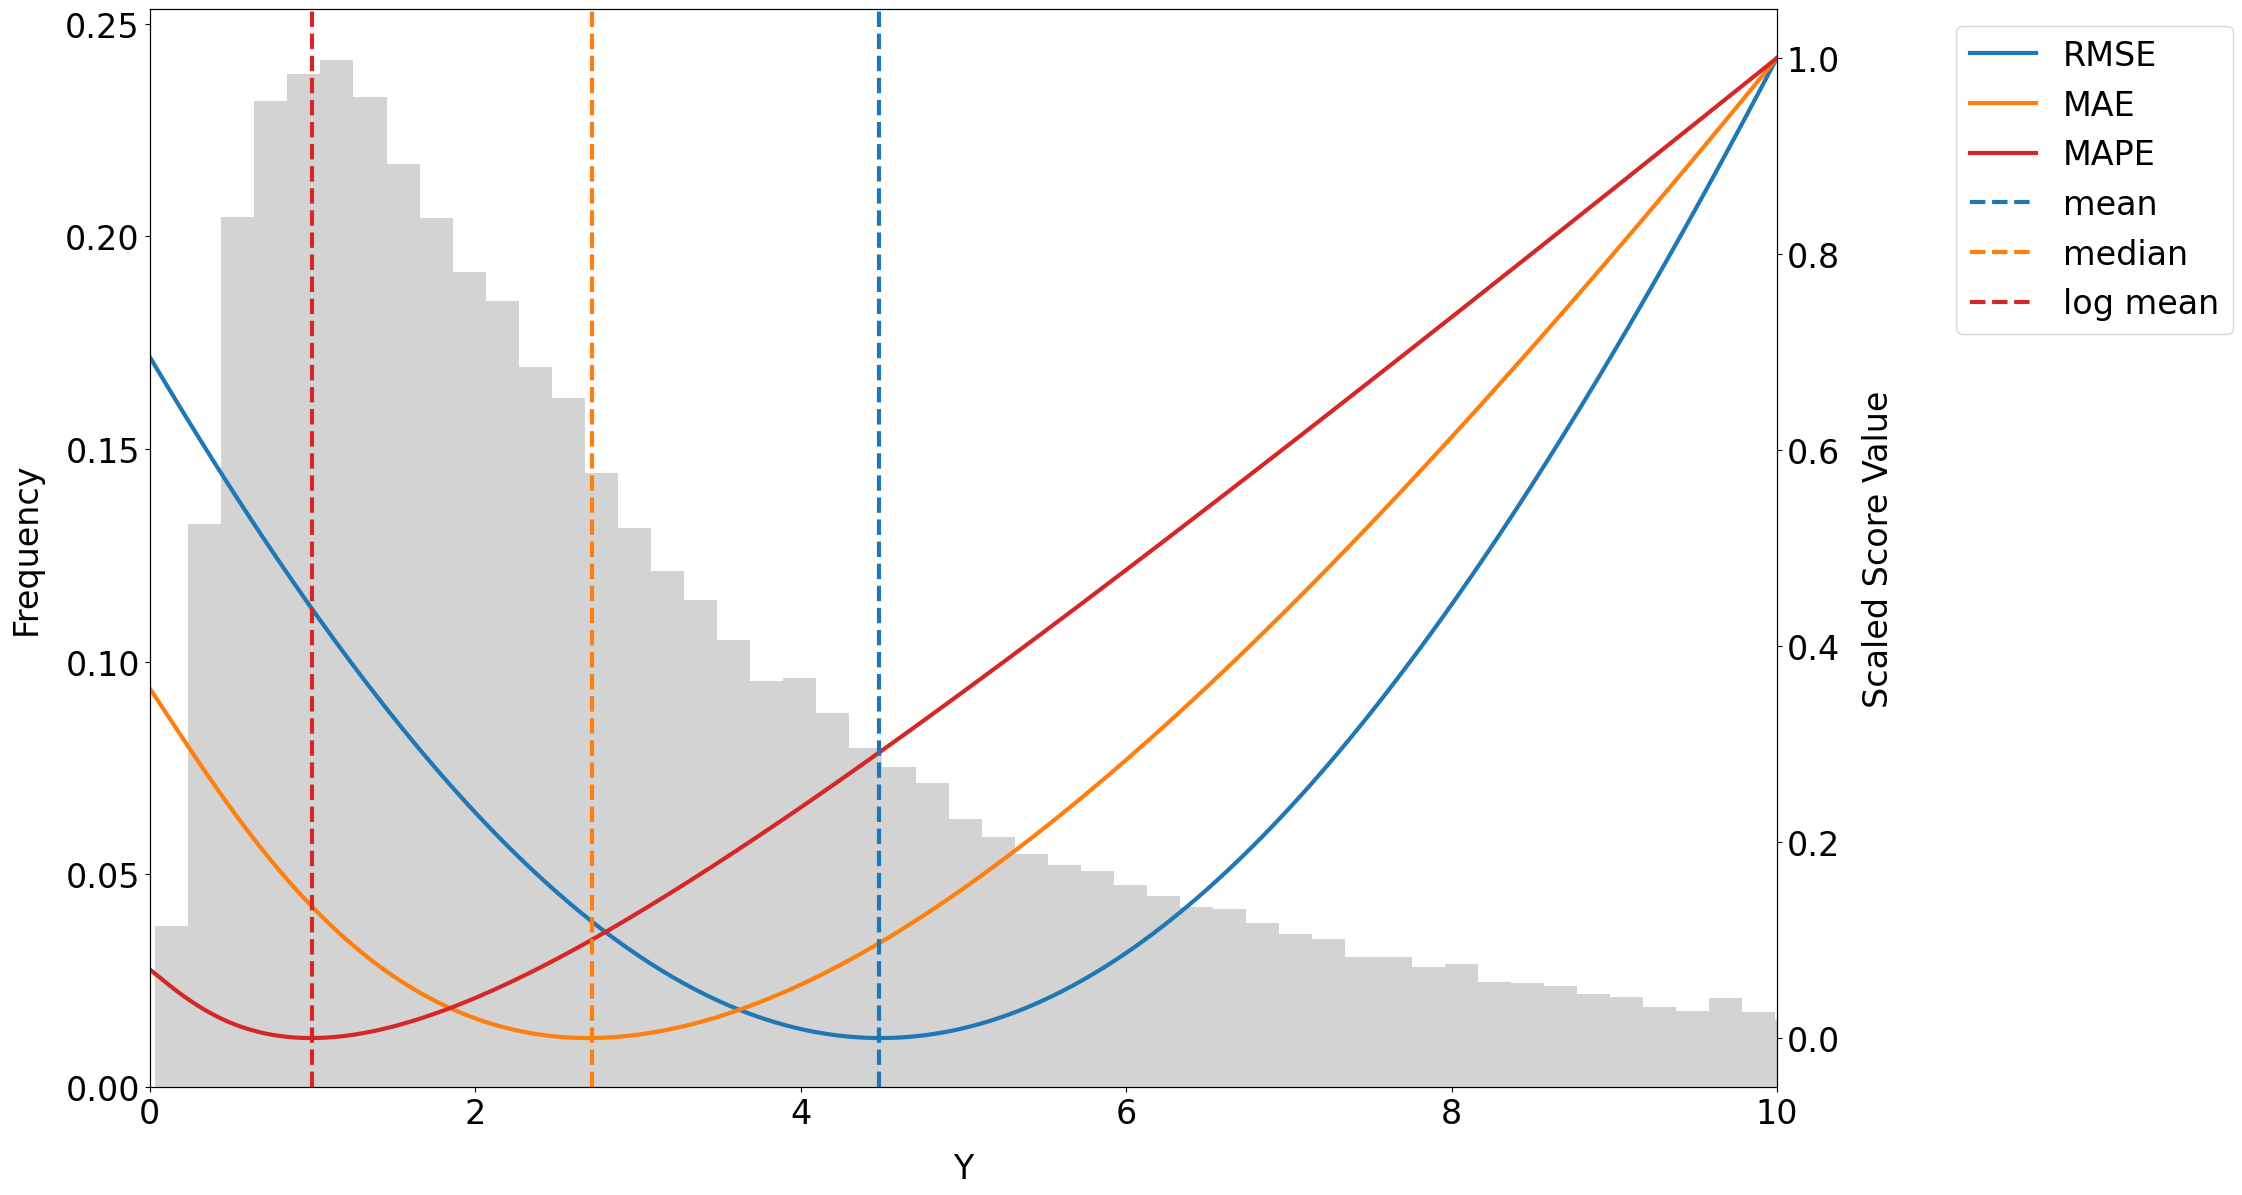

In [8]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

# plt.title(f"Metrics Comparison")
ax2.set_ylabel("Scaled Score Value")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Y")

ax1.hist(synthetic_ts, bins=2000, density=True, color="lightgrey")
ax2.plot(prediction_grid, rmse_prediction_grid, label="RMSE", color="C0")
ax2.plot(prediction_grid, mae_prediction_grid, label="MAE", color="C1")
ax2.plot(prediction_grid, mape_prediction_grid, label="MAPE", color="C3")
ax2.axvline(lognormal_mean(m, s), label="mean", color="C0", linestyle="dashed")
ax2.axvline(lognormal_median(m), label="median", color="C1", linestyle="dashed")
ax2.axvline(m, label="log mean", color="C3", linestyle="dashed")
# ax2.axvline(
#     prediction_grid[np.argmin(rmse_prediction_grid)], 
#     color="C4", 
#     linestyle="dashed", 
#     label="RMSE min"
# )
# ax2.axvline(
#     prediction_grid[np.argmin(mae_prediction_grid)], 
#     color="C2", 
#     linestyle="dashed", 
#     label="MAE min"
# )
# ax2.axvline(
#     prediction_grid[np.argmin(mape_prediction_grid)], 
#     color="C6", 
#     linestyle="dashed", 
#     label="MAPE min"
# )

plt.xlim(min_x, max_x)
ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
fig.savefig("images/cell13_lognormal_metrics_comparison.png", bbox_inches="tight", dpi=150)
plt.show()

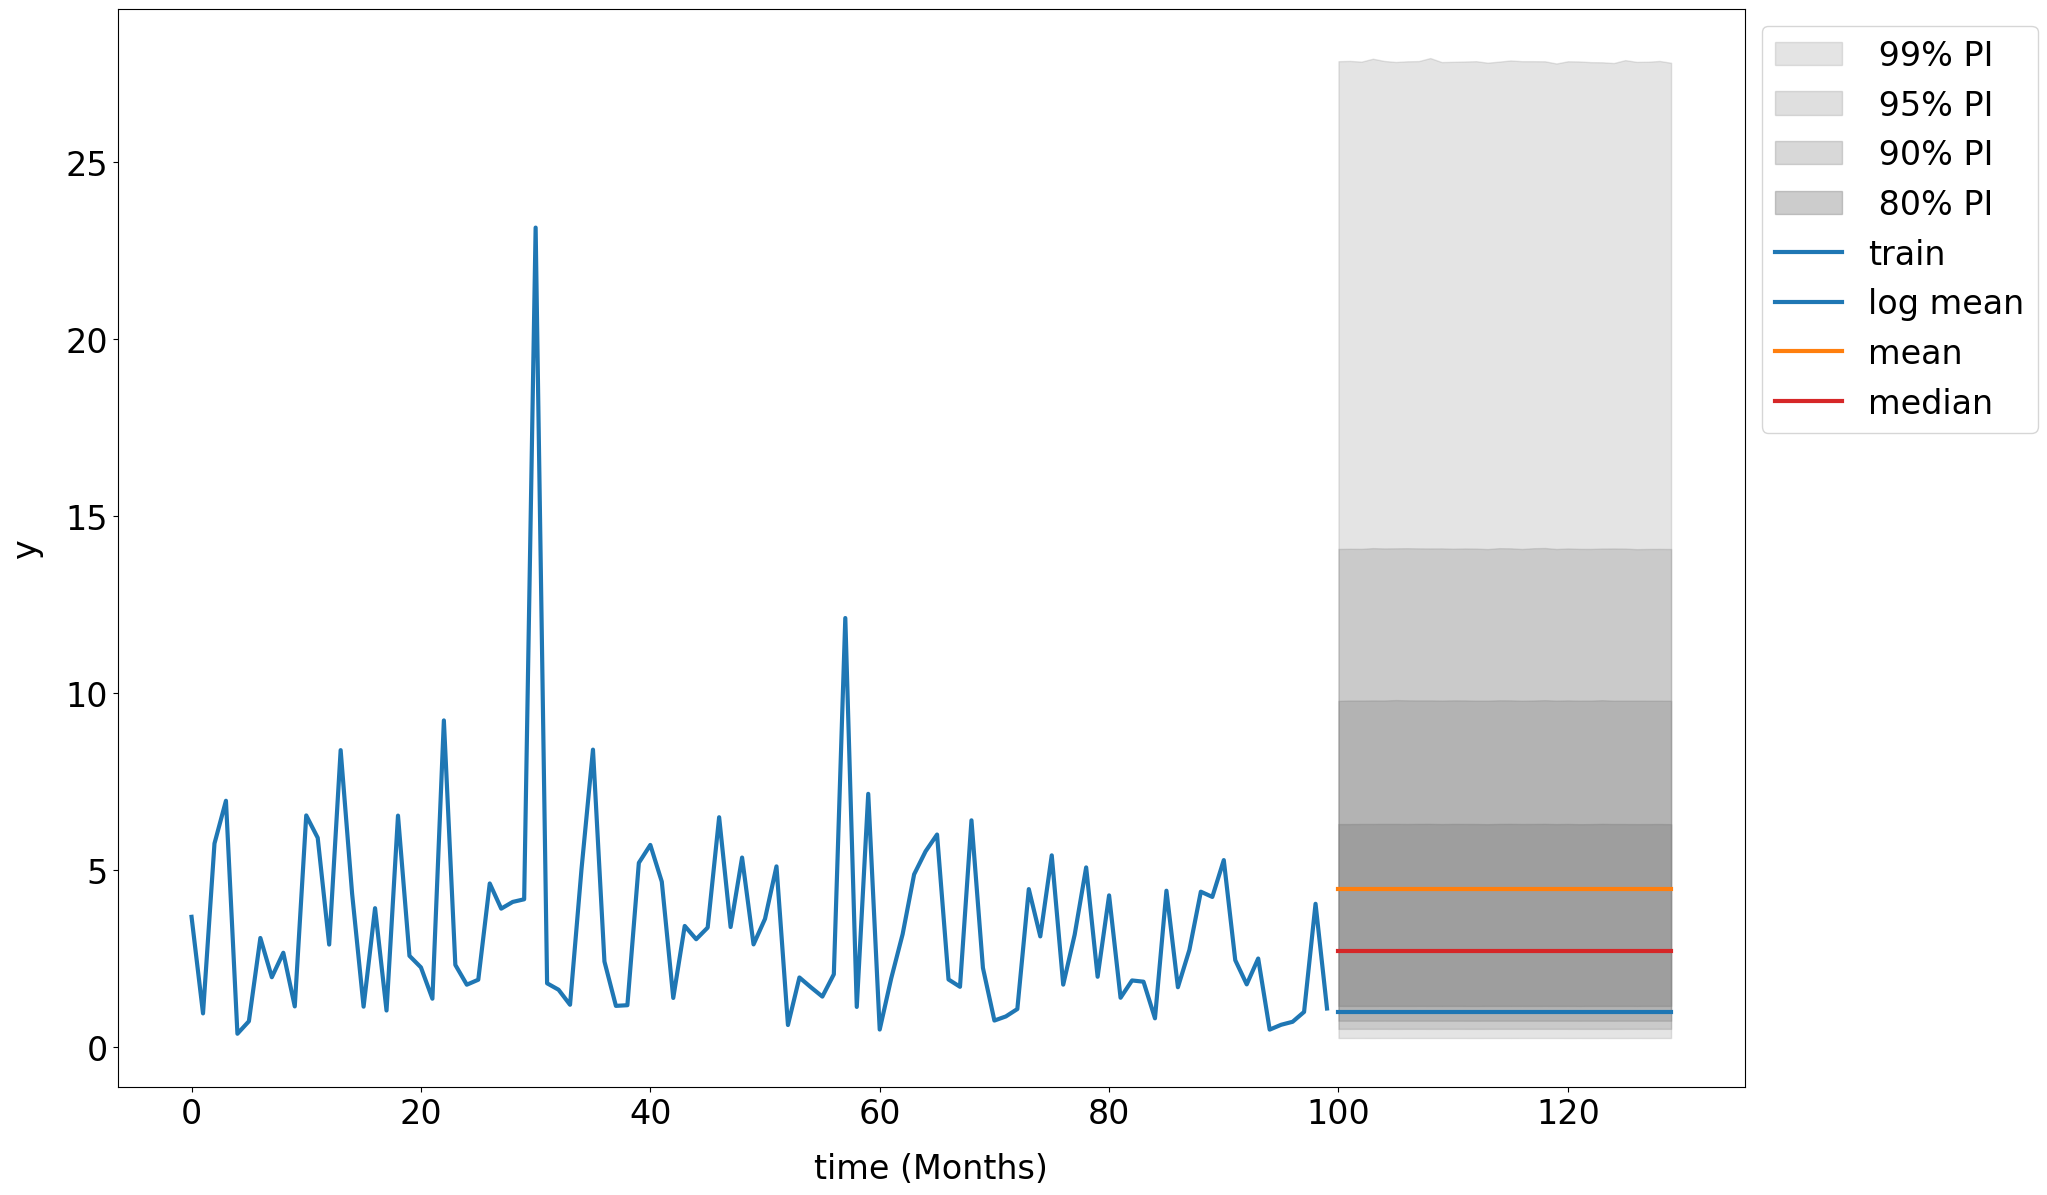

In [9]:
import pandas as pd

rng = np.random.default_rng(seed=42)
n_timepoints = 100
n_simulations = 10000000
horizon = 30
y_actuals = pd.Series(rng.lognormal(m, s, n_timepoints), index=np.arange(n_timepoints), name="y")
y_pred_index = np.arange(n_timepoints, n_timepoints+horizon)
y_simulations = pd.DataFrame(rng.lognormal(m, s, (horizon, n_simulations)), index=y_pred_index)

plot_prediction_intervals_from_simulations(
    y_actuals, y_simulations, [0.99, 0.95, 0.9, 0.8]
)

plt.plot(pd.DataFrame([m for _ in y_pred_index], index=y_pred_index), label="log mean", color="C0")
plt.plot(pd.DataFrame([lognormal_mean(m, s) for _ in y_pred_index], index=y_pred_index), label="mean", color="C1")
plt.plot(pd.DataFrame([lognormal_median(m) for _ in y_pred_index], index=y_pred_index), label="median", color="C3")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("images/cell14_lognormal_prediction_intervals.png", bbox_inches="tight", dpi=150)
plt.show()

## What forecast to choose grid?

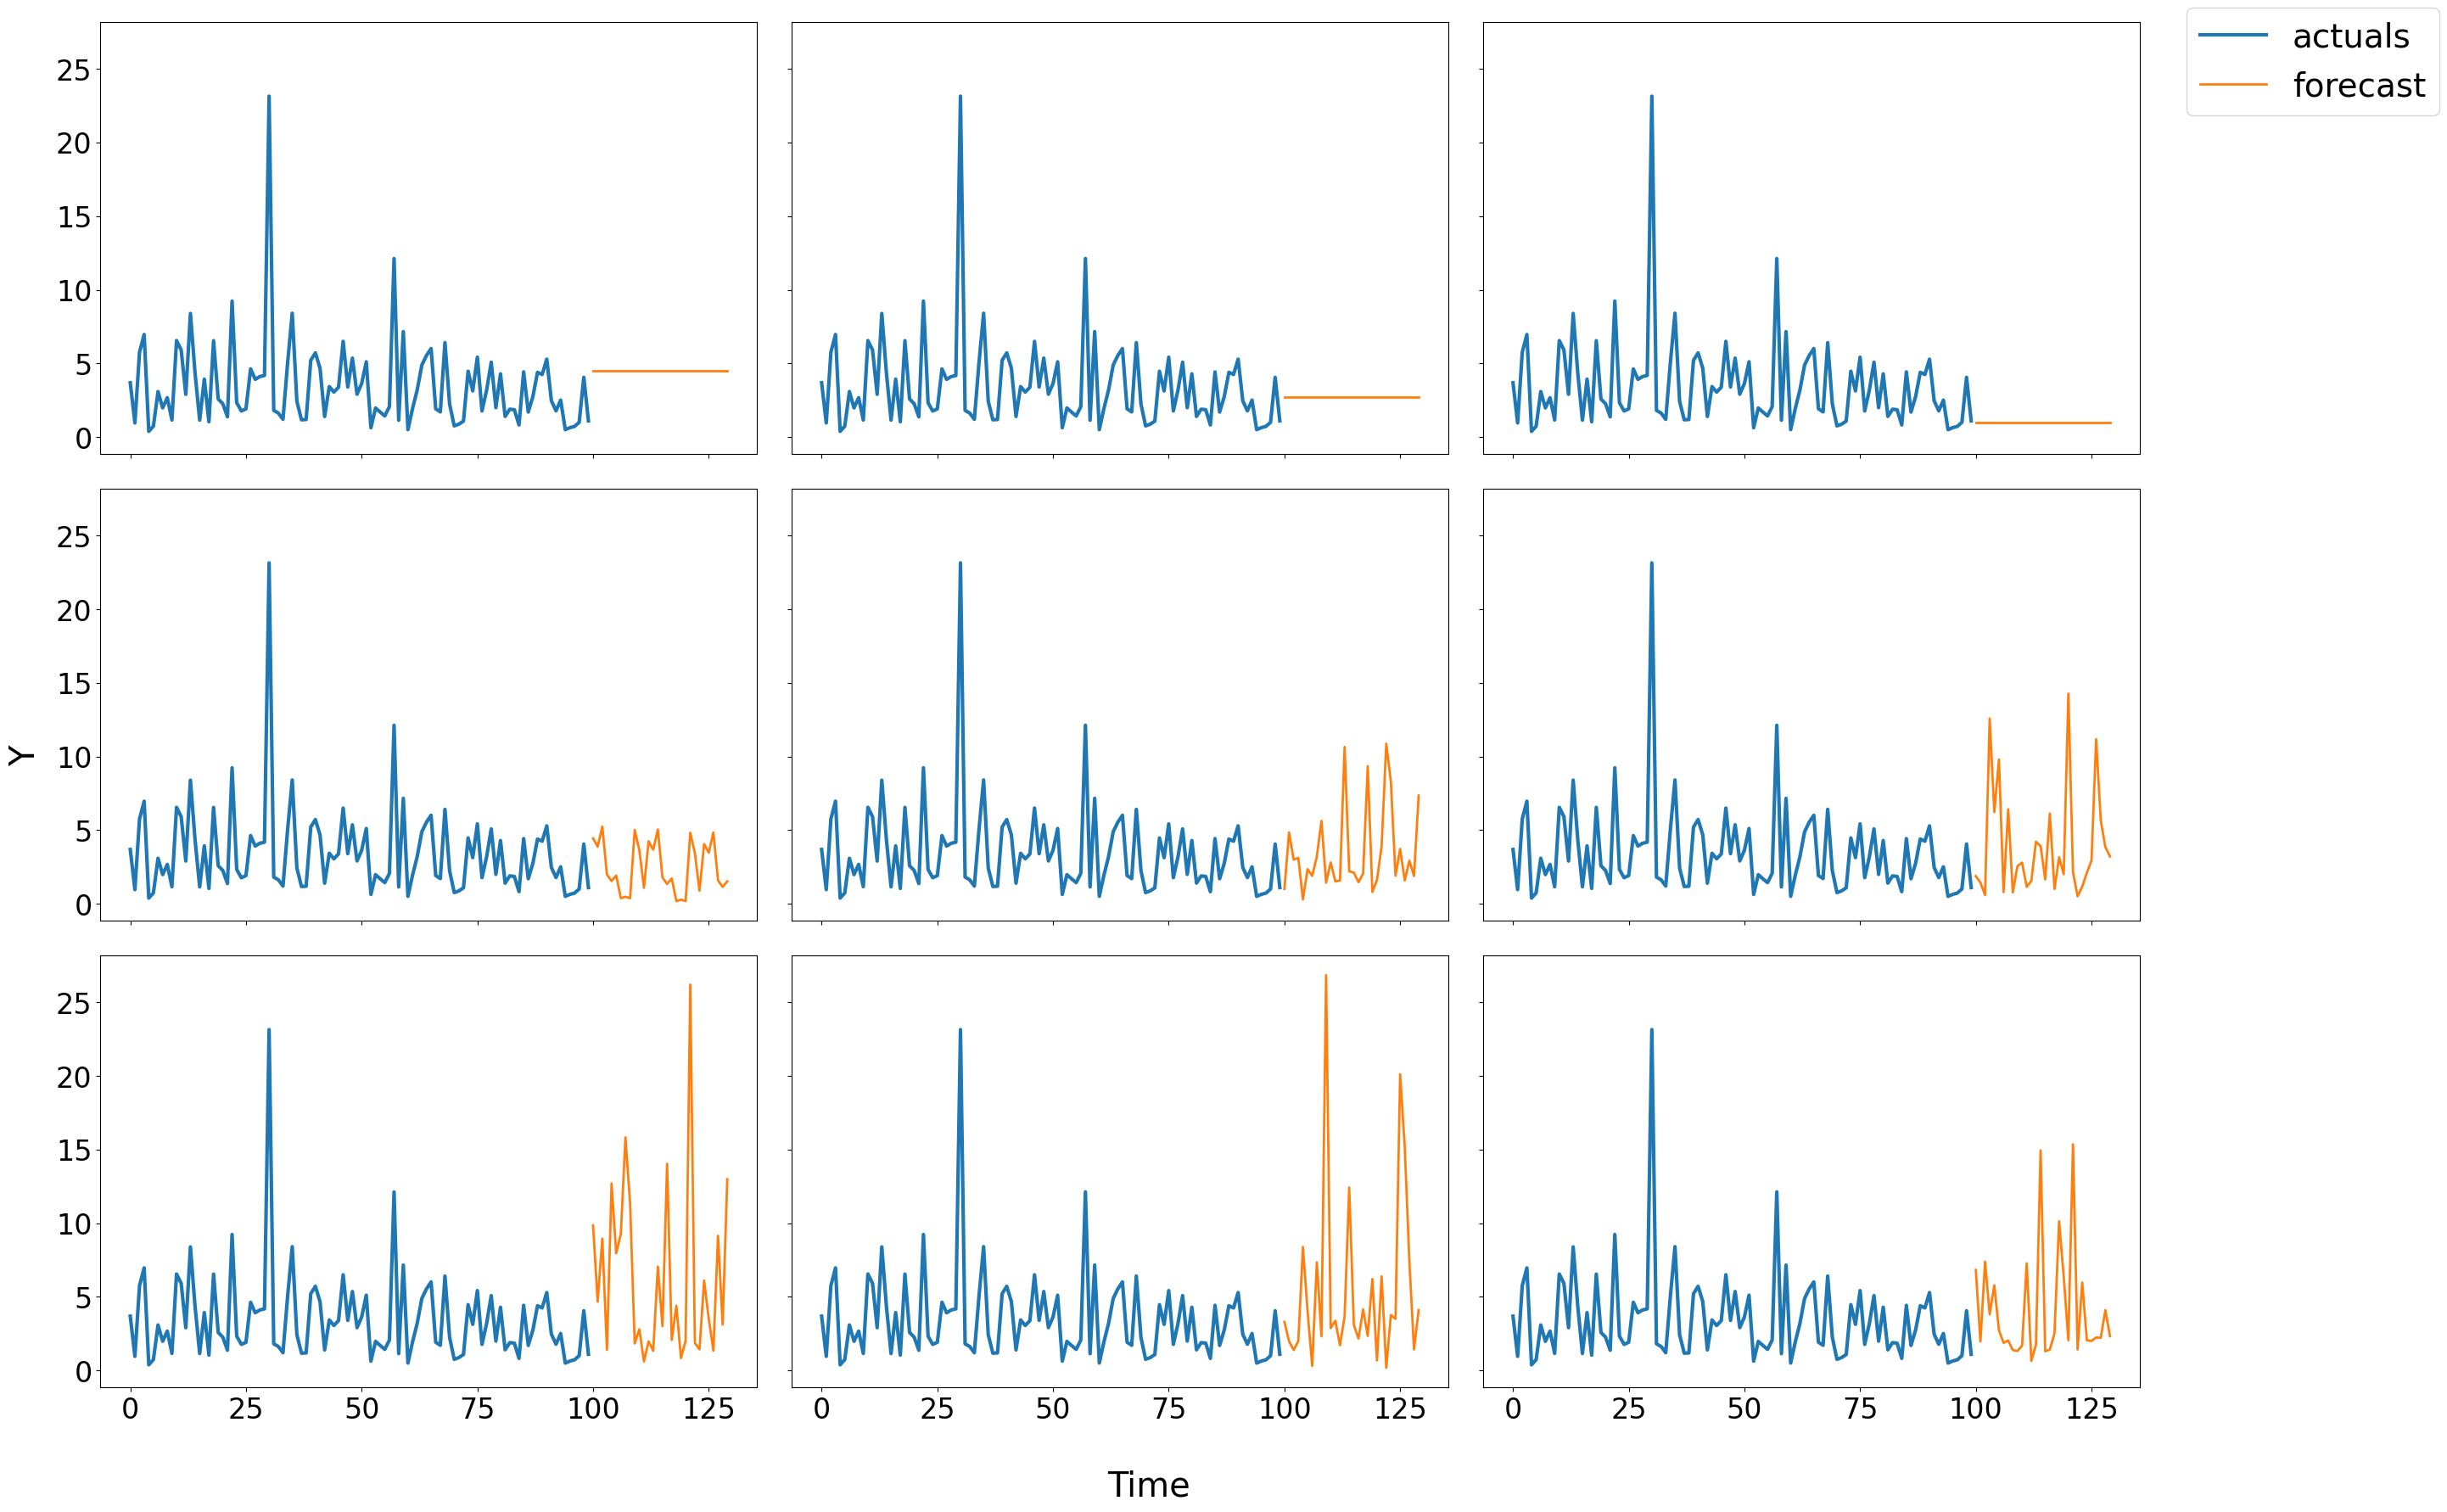

In [10]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Reset rng for reproducibility ---
rng = np.random.default_rng(seed=123)

# --- Data setup ---
forecast_index = y_pred_index

# --- Candidate forecasts ---
mean_forecast = np.full(horizon, lognormal_mean(m, s))
median_forecast = np.full(horizon, lognormal_median(m))
logmean_forecast = np.full(horizon, m)

# Random samples from the parent distribution
n_sample_paths = 5
sample_paths = rng.lognormal(m, s, (horizon, n_sample_paths))

# STL forecast using STLForecast
stl_fcast = STLForecast(
    y_actuals, ExponentialSmoothing, period=12, robust=True,
    model_kwargs={"trend": "add", "seasonal_periods": 12}
)
stl_result = stl_fcast.fit()
stl_forecast = stl_result.forecast(horizon).values

# --- Build plot configs: each sample path gets its own subplot ---
plot_configs = [
    ("Mean", mean_forecast),
    ("Median", median_forecast),
    ("Log Mean", logmean_forecast),
    ("STL Forecast", stl_forecast),
] + [
    (f"Random Sample {j+1}", sample_paths[:, j]) for j in range(n_sample_paths)
]

n_plots = len(plot_configs)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(28, 6 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, (_, fcast) in enumerate(plot_configs):
    ax = axes[i]
    ax.plot(y_actuals.index, y_actuals.values, color="C0", label="actuals")
    ax.plot(forecast_index, fcast, color="C1", linewidth=2, label="forecast")

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=1, fontsize=28, bbox_to_anchor=(0.93, 1.0))

fig.supxlabel("Time")
fig.supylabel("Y")
plt.tight_layout(rect=(0, 0, 0.93, 1))
fig.savefig("images/cell16_lognormal_forecast_grid.png", bbox_inches="tight", dpi=150)
plt.show()

# Normal Distribution

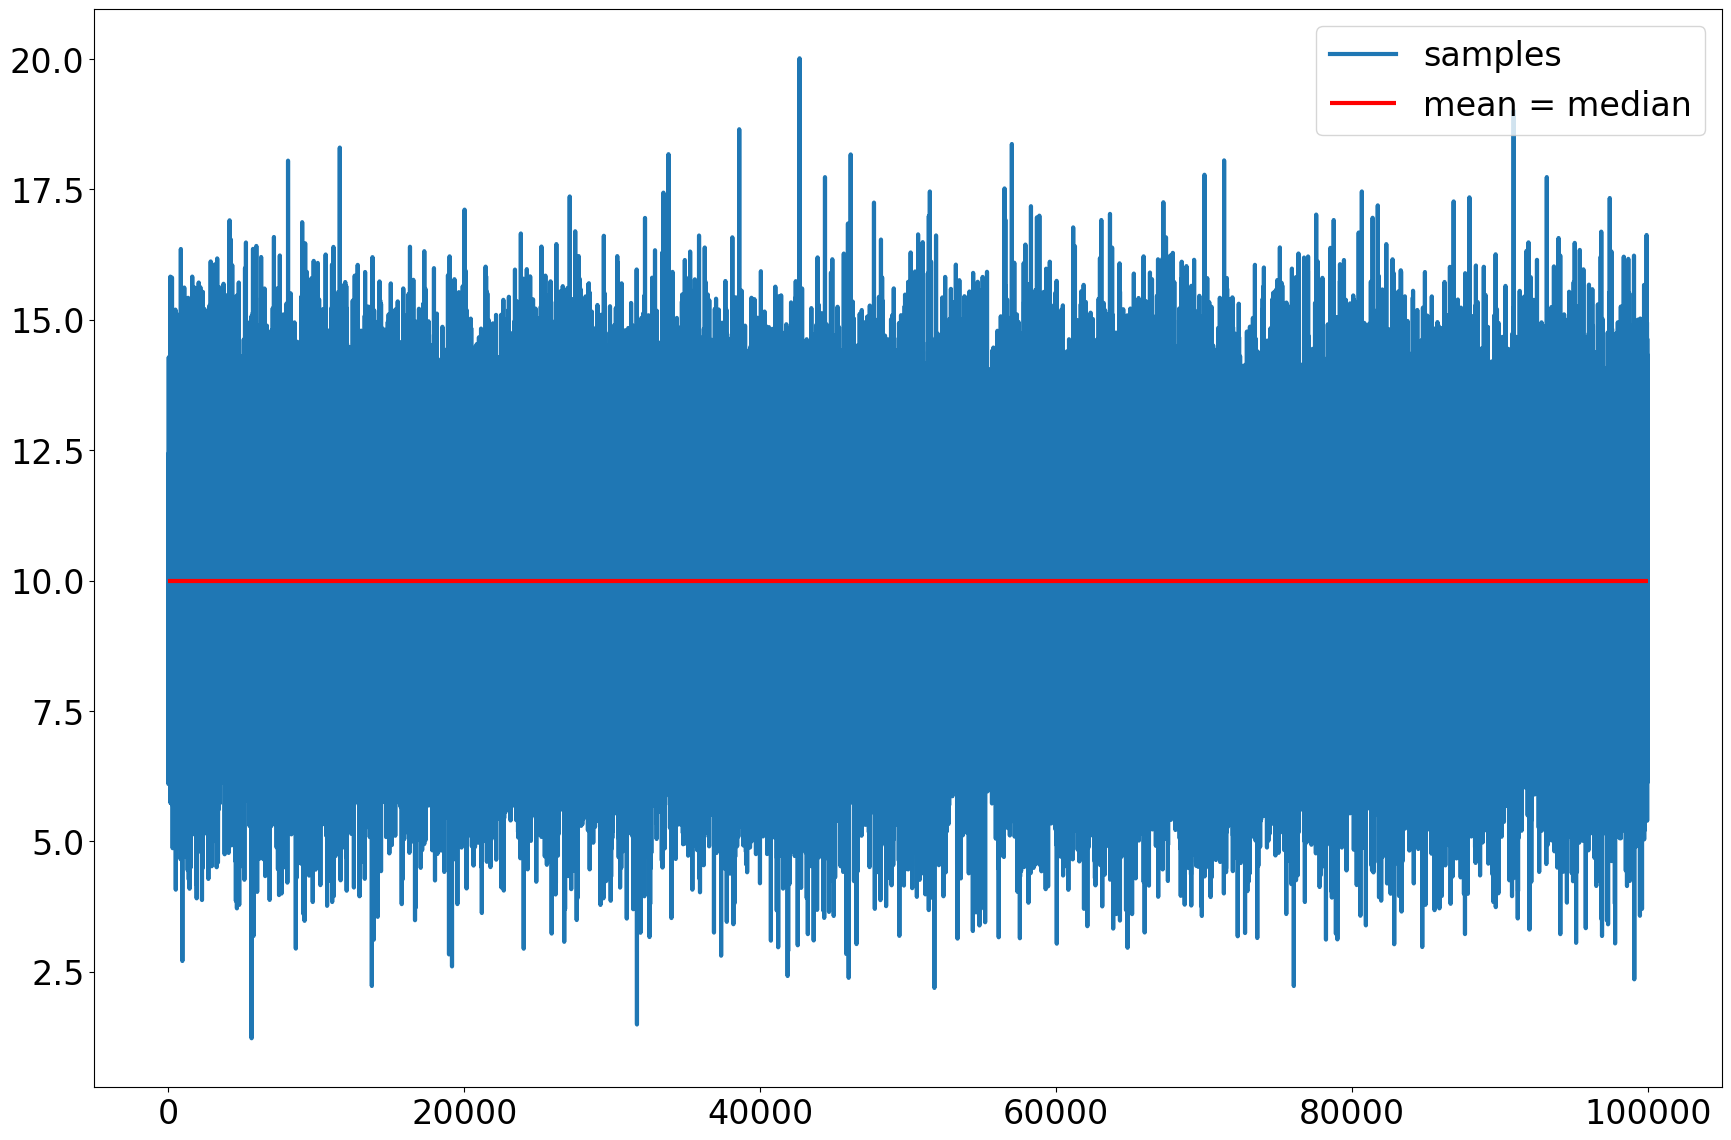

In [11]:
rng = np.random.default_rng(seed=42)

# Normal distribution parameters
mu_norm = 10
sigma_norm = 2
num_samples_norm = 100000
synthetic_ts_norm = rng.normal(mu_norm, sigma_norm, num_samples_norm).reshape(-1, 1)

plt.plot(synthetic_ts_norm, label="samples")
plt.hlines(mu_norm, 0, num_samples_norm, color="r", label="mean = median")
plt.legend()
plt.savefig("images/cell18_normal_synthetic_ts.png", bbox_inches="tight", dpi=150)
plt.show()

In [12]:
min_x_norm = float(synthetic_ts_norm.min())
max_x_norm = float(synthetic_ts_norm.max())
prediction_grid_norm = np.arange(min_x_norm, max_x_norm, step=0.001).reshape(-1, 1)
rmse_prediction_grid_norm = minmax_scale(rmse(synthetic_ts_norm.T, prediction_grid_norm))
mae_prediction_grid_norm = minmax_scale(mae(synthetic_ts_norm.T, prediction_grid_norm))
mape_prediction_grid_norm = minmax_scale(mape(synthetic_ts_norm.T, prediction_grid_norm))

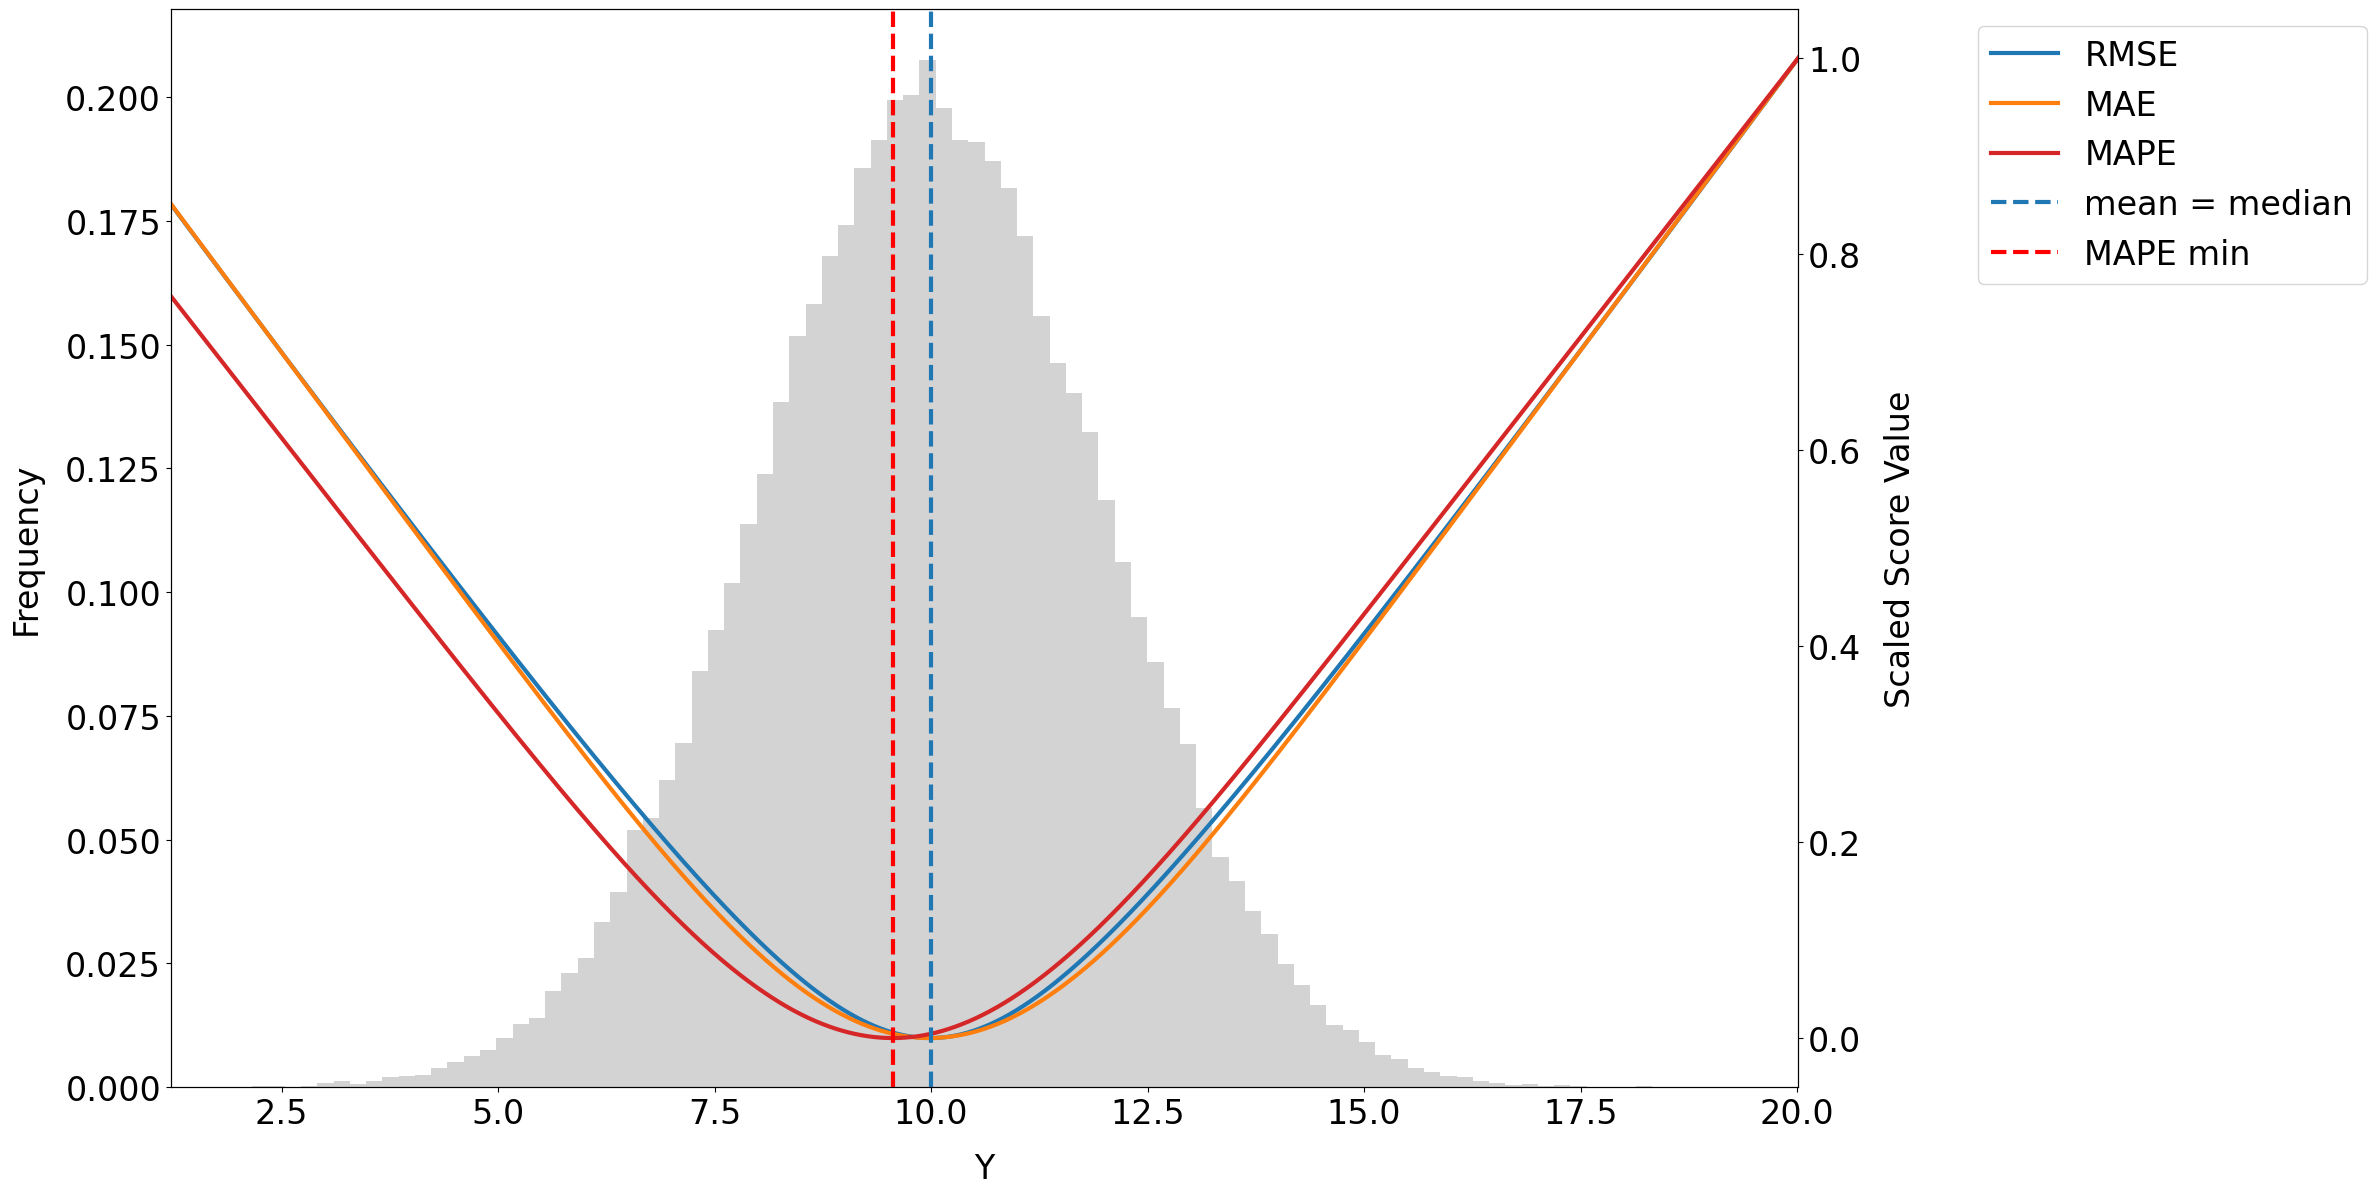

In [13]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.set_ylabel("Scaled Score Value")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Y")

ax1.hist(synthetic_ts_norm, bins=100, density=True, color="lightgrey")
ax2.plot(prediction_grid_norm, rmse_prediction_grid_norm, label="RMSE", color="C0")
ax2.plot(prediction_grid_norm, mae_prediction_grid_norm, label="MAE", color="C1")
ax2.plot(prediction_grid_norm, mape_prediction_grid_norm, label="MAPE", color="C3")
ax2.axvline(mu_norm, label="mean = median", color="C0", linestyle="dashed")
mape_min_x = prediction_grid_norm[np.argmin(mape_prediction_grid_norm)][0]
ax2.axvline(mape_min_x, label="MAPE min", color="red", linestyle="dashed")

plt.xlim(min_x_norm, max_x_norm)

ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
fig.savefig("images/cell20_normal_metrics_comparison.png", bbox_inches="tight", dpi=150)
plt.show()

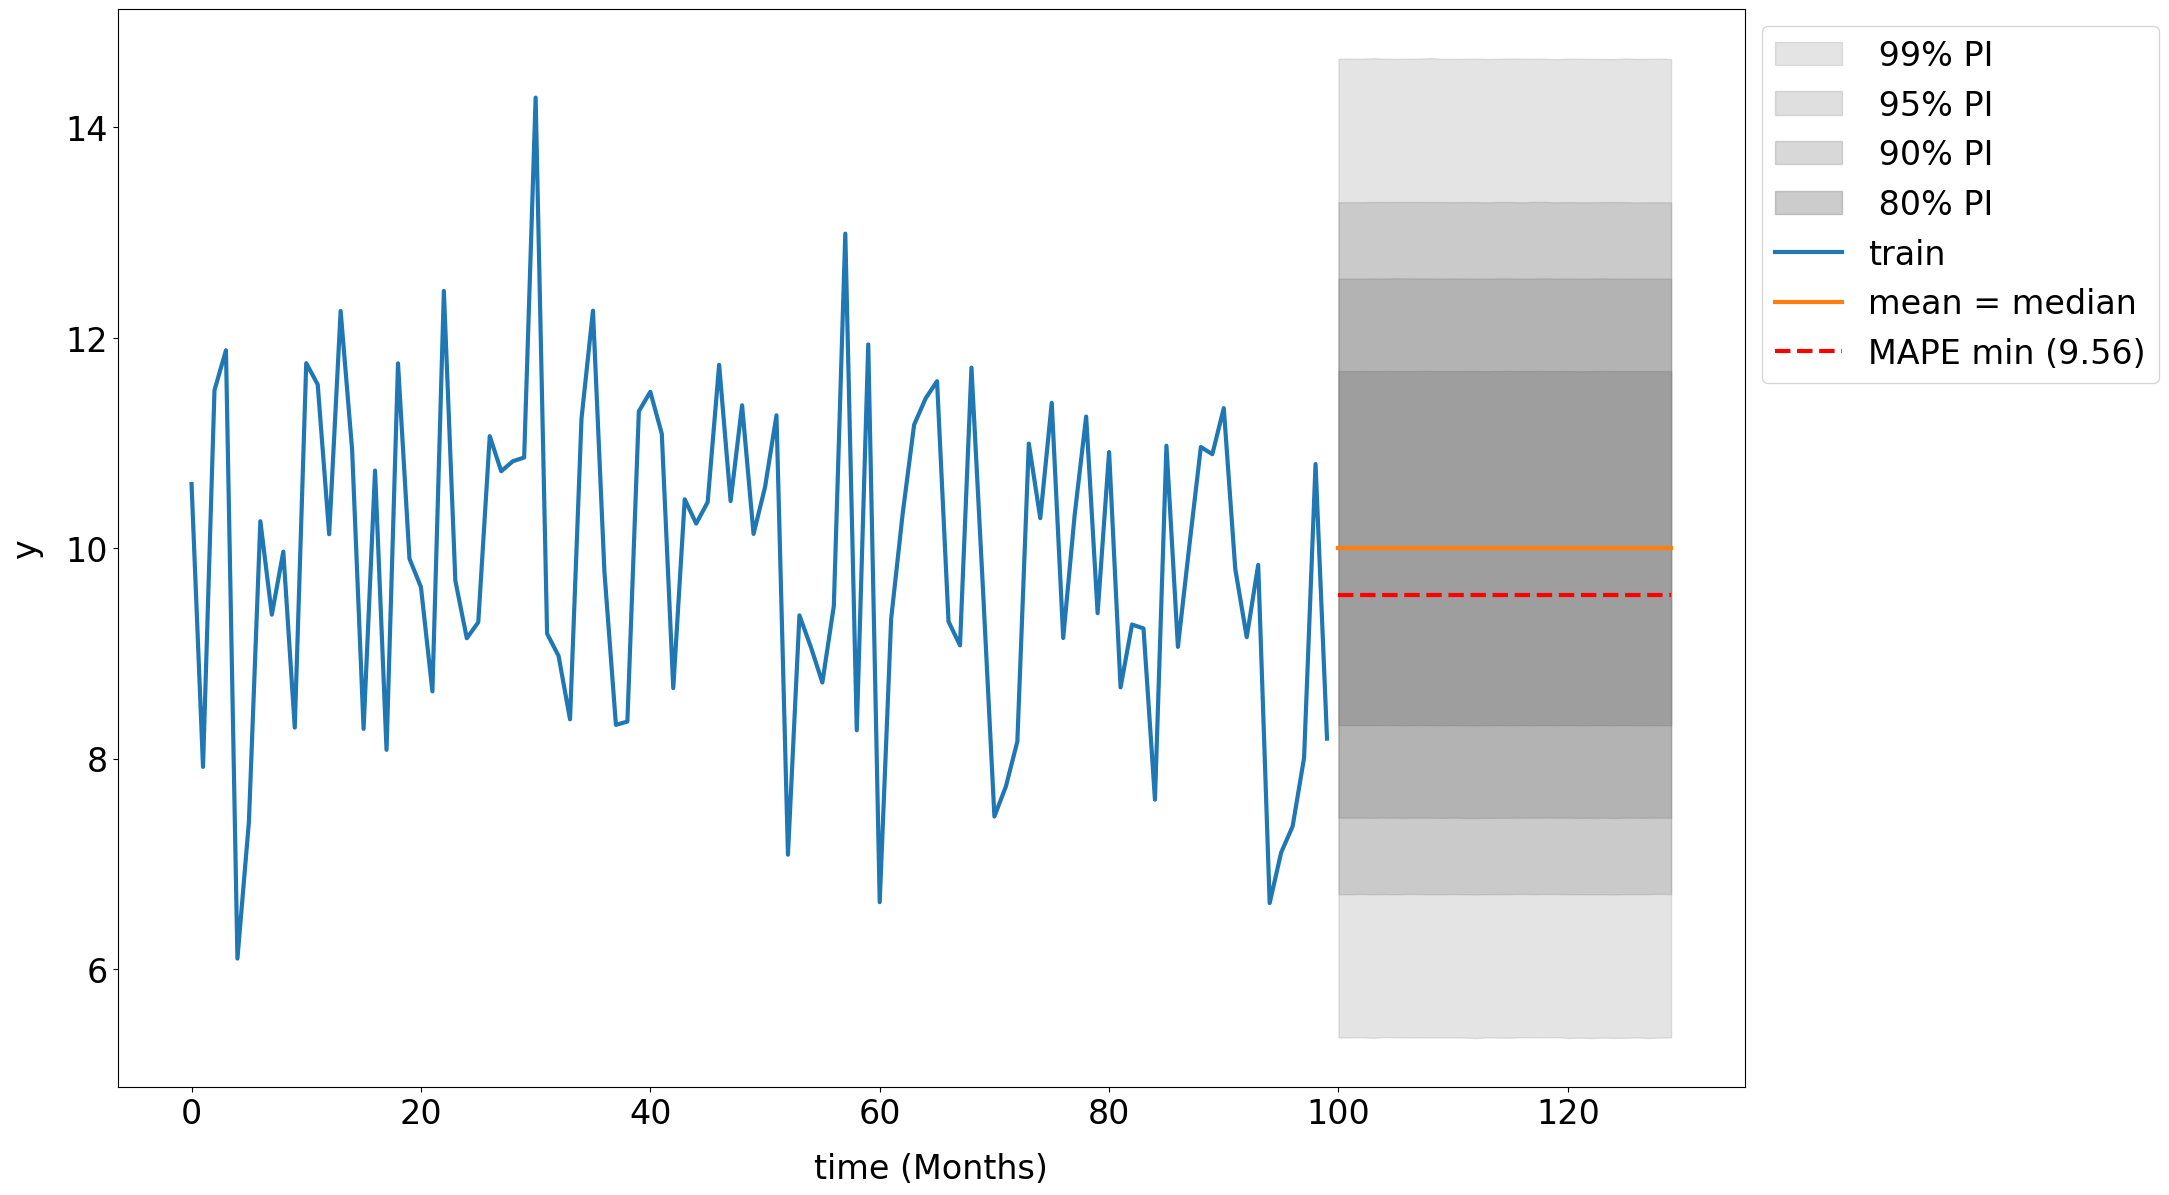

In [14]:
rng = np.random.default_rng(seed=42)
n_timepoints_norm = 100
n_simulations_norm = 10000000
horizon_norm = 30
y_actuals_norm = pd.Series(rng.normal(mu_norm, sigma_norm, n_timepoints_norm), index=np.arange(n_timepoints_norm), name="y")
y_pred_index_norm = np.arange(n_timepoints_norm, n_timepoints_norm + horizon_norm)
y_simulations_norm = pd.DataFrame(rng.normal(mu_norm, sigma_norm, (horizon_norm, n_simulations_norm)), index=y_pred_index_norm)

plot_prediction_intervals_from_simulations(
    y_actuals_norm, y_simulations_norm, [0.99, 0.95, 0.9, 0.8]
)

plt.plot(pd.DataFrame([mu_norm for _ in y_pred_index_norm], index=y_pred_index_norm), label="mean = median", color="C1")
plt.plot(pd.DataFrame([mape_min_x for _ in y_pred_index_norm], index=y_pred_index_norm), label=f"MAPE min ({mape_min_x:.2f})", color="red", linestyle="dashed")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("images/cell21_normal_prediction_intervals.png", bbox_inches="tight", dpi=150)
plt.show()

## What forecast to choose grid? (Normal)

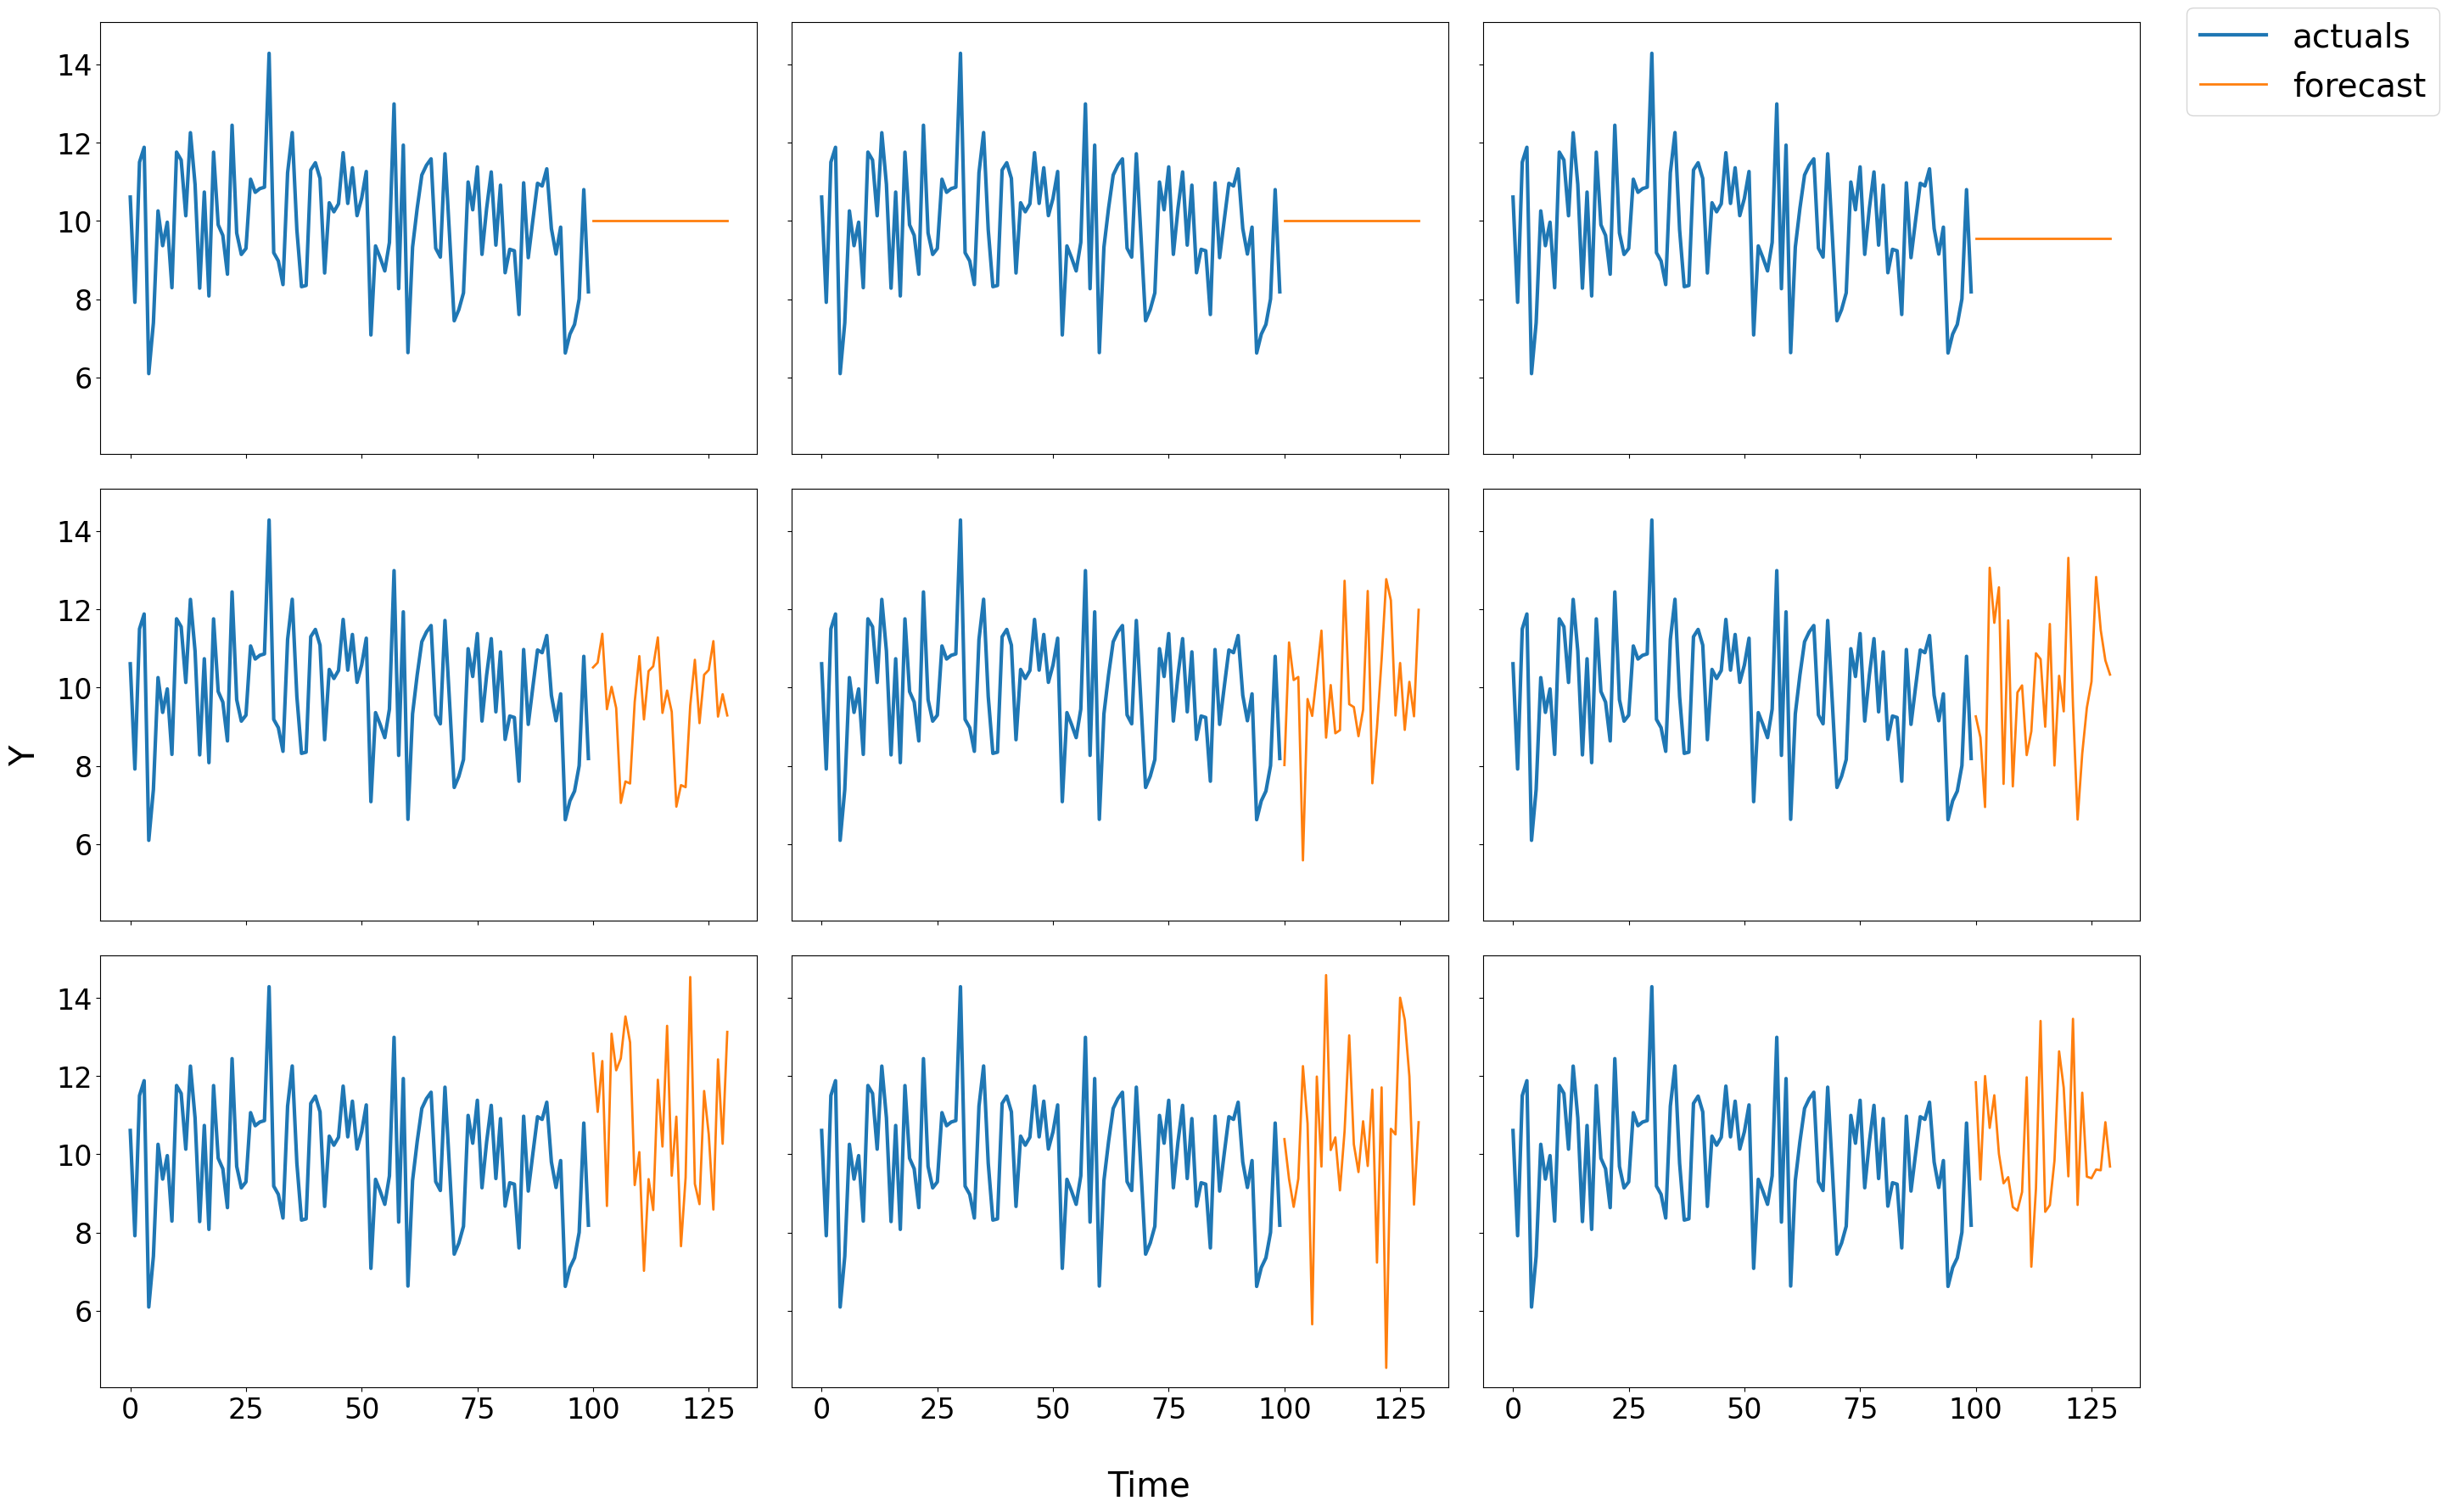

In [15]:
# --- Reset rng for reproducibility ---
rng = np.random.default_rng(seed=123)

# --- Data setup ---
forecast_index_norm = y_pred_index_norm

# --- Candidate forecasts ---
mean_forecast_norm = np.full(horizon_norm, mu_norm)
median_forecast_norm = np.full(horizon_norm, mu_norm)  # mean = median for normal
mape_min_forecast_norm = np.full(horizon_norm, mape_min_x)

# Random samples from the parent distribution
n_sample_paths_norm = 5
sample_paths_norm = rng.normal(mu_norm, sigma_norm, (horizon_norm, n_sample_paths_norm))

# STL forecast using STLForecast
stl_fcast_norm = STLForecast(
    y_actuals_norm, ExponentialSmoothing, period=12, robust=True,
    model_kwargs={"trend": "add", "seasonal_periods": 12}
)
stl_result_norm = stl_fcast_norm.fit()
stl_forecast_norm = stl_result_norm.forecast(horizon_norm).values

# --- Build plot configs: each sample path gets its own subplot ---
plot_configs_norm = [
    ("Mean", mean_forecast_norm),
    ("Median", median_forecast_norm),
    ("MAPE Min", mape_min_forecast_norm),
    ("STL Forecast", stl_forecast_norm),
] + [
    (f"Random Sample {j+1}", sample_paths_norm[:, j]) for j in range(n_sample_paths_norm)
]

n_plots_norm = len(plot_configs_norm)
n_cols_norm = 3
n_rows_norm = int(np.ceil(n_plots_norm / n_cols_norm))

fig, axes = plt.subplots(n_rows_norm, n_cols_norm, figsize=(28, 6 * n_rows_norm), sharex=True, sharey=True)
axes = axes.flatten()

for i, (_, fcast) in enumerate(plot_configs_norm):
    ax = axes[i]
    ax.plot(y_actuals_norm.index, y_actuals_norm.values, color="C0", label="actuals")
    ax.plot(forecast_index_norm, fcast, color="C1", linewidth=2, label="forecast")

# Hide unused subplots
for i in range(n_plots_norm, len(axes)):
    axes[i].set_visible(False)

# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=1, fontsize=28, bbox_to_anchor=(0.93, 1.0))

fig.supxlabel("Time")
fig.supylabel("Y")
plt.tight_layout(rect=[0, 0, 0.93, 1])
fig.savefig("images/cell23_normal_forecast_grid.png", bbox_inches="tight", dpi=150)
plt.show()